# Analysis 2
- Outcome: EAC
- Model: Logistic regression
- Risk score: predicted score from logreg model
- Feature selection: Significant variables based on univariate and multivariate analysis
- Drop patients with missing sex 

## Import libraries

In [1]:
%load_ext rpy2.ipython 
# Load the R magic extension

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, confusion_matrix
from scipy.stats import percentileofscore
import patsy
from lifelines import CoxPHFitter 
import statsmodels as sm
from pathlib import Path
from functools import reduce

In [3]:
# Add the directory to sys.path
import sys
module_path = Path('./../code')
sys.path.append(str(module_path))
import utils

In [4]:
# Import libraries to allow data to be passed between Python and R env
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects import r

pandas2ri.activate()

In [5]:
%%R
library(bshazard)
library(survival)
library(tidyr)
library(dplyr)
library(magrittr)
library(tableone)
library(pROC)
library(PRROC)
library(caret)
library(survivalROC)
library(survminer)
library(scales)
library(finalfit)
library(broom)
library(broom.helpers)
library(purrr)

R[write to console]: Loading required package: splines

R[write to console]: Loading required package: survival

R[write to console]: Loading required package: Epi

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘magrittr’


R[write to console]: The following object is masked from ‘package:tidyr’:

    extract


R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Loading required package: rlang

R[write to console]: 
Attaching package: ‘rlang’


R[write to console]: The following object is masked from ‘package:magrittr’:

    set_names


R[write to consol

In [6]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

# Displays all the columns, does 
pd.set_option('display.max_columns', None)

## Import data

In [7]:
%%R 
r_df_normal <- read.csv("df_analysis0_imputed.csv")

In [66]:
univariate_filename = './../results/univariate_analysis_2_eac.csv'
multivariate_filename = './../results/multivariate_analysis_2_eac.csv'
risk_results_filename = './../results/risk_results_analysis_2_eac.csv'
risk_results_race_filename = './../results/risk_results_race_analysis_2_eac.csv'

In [9]:
# Pass the DataFrame into the R environment
def pass_df(df, r_df_name):
    ro.globalenv[r_df_name] = df

ro.globalenv['numerical_vars'] = utils.NUMERICAL_VARS
ro.globalenv['categorical_vars'] = utils.CATEGORICAL_VARS 
ro.globalenv['univariate_filename'] = str(univariate_filename)
ro.globalenv['multivariate_filename'] = str(multivariate_filename)

## Univariate analysis - logistic regression

In [10]:
%%R 
# Ignore these columns
cols_to_ignore <- c(
    'months_to_event', 'ugica', 'ugica_ESCC', 'ugica_EAC', 'ugica_CGC', 'ugica_NCGC', 
    'death', 'subtype', 'visit_year', 'diagnosis_year', 'encounter_type', 'social_language', 
    'days_to_event', 'days_to_dx', 'days_to_death',
    "eac_risk_factors_screening", "meets_screening",
    "hgball_baseline_imputed_mean"
)

subtype_outcomes <- c('ugica_ESCC', 'ugica_EAC', 'ugica_CGC', 'ugica_NCGC')

### Factorize categorical vars and set reference levels

In [11]:
%%R
# Remove categorical variables that we do not want to do univariate analysis on
vars_categorical_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore &
    names(r_df_normal) %in% categorical_vars
]

# Factorize 
for (i in vars_categorical_for_univariate) {
    r_df_normal[[i]] <- factor(r_df_normal[[i]])
}

# Set reference levels 
r_df_normal$race_clean <- relevel(r_df_normal$race_clean, ref = 'White')
r_df_normal$race_clean_missing <- relevel(r_df_normal$race_clean_missing, ref = 'White')
r_df_normal$ethnicity <- relevel(r_df_normal$ethnicity, ref='Not Hispanic or Latino')
r_df_normal$ethnicity_missing <- relevel(r_df_normal$ethnicity_missing, ref='Not Hispanic or Latino')
r_df_normal$alcohol_all <- relevel(r_df_normal$alcohol_all, ref = '0.0')
# r_df_normal$alcohol_all_missing <- relevel(r_df_normal$alcohol_all_missing, ref = '0')
r_df_normal$alcohol_binary <- relevel(r_df_normal$alcohol_binary, ref = '0')
# r_df_normal$alcohol_binary_missing <- relevel(r_df_normal$alcohol_binary_missing, ref = '0')
r_df_normal$tobacco_all <- relevel(r_df_normal$tobacco_all, ref = '0.0')
r_df_normal$tobacco_all_missing <- relevel(r_df_normal$tobacco_all_missing, ref = '0')
r_df_normal$tobacco_binary <- relevel(r_df_normal$tobacco_binary, ref = '0')
r_df_normal$tobacco_binary_missing <- relevel(r_df_normal$tobacco_binary_missing, ref = '0')
r_df_normal$hpylori_active <- relevel(r_df_normal$hpylori_active, ref = '0.0')
# r_df_normal$hpylori_active_missing <- relevel(r_df_normal$hpylori_active_missing, ref = '0')
r_df_normal$hpylori_active_chronic <- relevel(r_df_normal$hpylori_active_chronic, ref = '0.0')
# r_df_normal$hpylori_active_chronic_missing <- relevel(r_df_normal$hpylori_active_chronic_missing, ref = '0')
r_df_normal$hpylori_active_chronic_binary <- relevel(r_df_normal$hpylori_active_chronic_binary, ref = '0')

In [12]:
%%R
vars_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore
]
vars_for_univariate

 [1] "sex"                           "sex_missing"                  
 [3] "race_clean"                    "race_clean_missing"           
 [5] "ethnicity"                     "ethnicity_missing"            
 [7] "alcohol_all"                   "alcohol_binary"               
 [9] "tobacco_all"                   "tobacco_all_missing"          
[11] "tobacco_binary"                "tobacco_binary_missing"       
[13] "hpylori_active"                "hpylori_active_chronic"       
[15] "hpylori_active_chronic_binary" "hnca"                         
[17] "achalasia"                     "pud"                          
[19] "gerd"                          "cad"                          
[21] "barretts"                      "famhx_cancer"                 
[23] "famhx_esophagealca"            "famhx_gastricca"              
[25] "famhx_colonca"                 "famhx_barretts"               
[27] "ASA"                           "PPI"                          
[29] "NSAID"                      

In [13]:
%%R
vars_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore
]

# HRs, 95% CIs, p-values
results_list <- list()

for (i in vars_for_univariate) {
    # Skip if fewer than 2 levels, ie. 100% in one group
    if (length(unique(na.omit(r_df_normal[[i]]))) < 2) next

    # Build formula
    formula <- as.formula(paste("ugica_EAC ~", i))
    
    model <- glm(formula, data=r_df_normal, family = binomial)

    model_summary <- summary(model)

    # Get odds ratios and confidence intervals
    coef <- exp(coef(model))
    confint_vals <- exp(confint(model))  # 95% CI for log-odds, exponentiated to OR
    p_value <- coef(summary(model))[, "Pr(>|z|)"]

    # Extract full term names (e.g., "sexMale", "stageIII")
    terms <- rownames(coef(summary(model)))

    # Extract factor levels (remove variable name prefix)
    is_factor <- i %in% categorical_vars
    levels_clean <- if (is_factor) {
        sub(paste0("^", i), "", terms)
    } else {
        terms  # use full term name for numeric variables
    }

    model_df <- data.frame(
        Variable = i,
        Level = levels_clean,
        OR = coef[terms],
        CI_lower = confint_vals[terms, 1],
        CI_upper = confint_vals[terms, 2],
        p_value = p_value[terms]
    )

    results_list[[i]] <- model_df
}

final_results <- do.call(rbind, results_list)
write.csv(final_results, univariate_filename)

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to con

In [14]:
# Print the list of significant variables based on univariate analysis
df_univariate = pd.read_csv(univariate_filename)

In [15]:
df_univariate[df_univariate.p_value < 0.05]

,Unnamed: 0,Variable,Level,OR,CI_lower,CI_upper,p_value
0,sex.(Intercept),sex,(Intercept),0.000009,0.000004,0.000016,6.670514e-239
1,sex.sexMALE,sex,MALE,8.677913,4.407779,19.665003,9.422313e-09
3,sex_missing.(Intercept),sex_missing,(Intercept),0.000009,0.000004,0.000016,6.543721e-239
4,sex_missing.sex_missingMALE,sex_missing,MALE,8.677913,4.407782,19.664985,9.417354e-09
5,race_clean.(Intercept),race_clean,(Intercept),0.000072,0.000053,0.000095,0.000000e+00
7,race_clean.race_cleanBlack or African American,race_clean,Black or African American,0.327646,0.113657,0.747796,1.769046e-02
8,race_clean.race_cleanNo matching concept,race_clean,No matching concept,0.298583,0.164188,0.514845,2.967828e-05
10,race_clean_missing.(Intercept),race_clean_missing,(Intercept),0.000072,0.000053,0.000095,0.000000e+00
12,race_clean_missing.race_clean_missingBlack or ...,race_clean_missing,Black or African American,0.327646,0.113657,0.747796,1.769046e-02
14,ethnicity.(Intercept),ethnicity,(Intercept),0.000052,0.000038,0.000068,0.000000e+00


## Feature selection

In [78]:
%%R 
selected_vars <- final_results %>%
    filter(Level != "(Intercept)") %>%
    filter(p_value < 0.05) %>%
    distinct(Variable) %>%
    pull(Variable)
selected_vars

duplicate_vars <- c("sex", "race_clean_missing", "weight_baseline", "ethnicity_missing", "tobacco_all", "tobacco_all_missing", "tobacco_binary_missing", "barretts")
selected_vars <- selected_vars[
    !selected_vars %in% duplicate_vars &
    !selected_vars %in% cols_to_ignore]
selected_vars

 [1] "sex_missing"     "race_clean"      "ethnicity"       "tobacco_binary" 
 [5] "hnca"            "pud"             "gerd"            "cad"            
 [9] "famhx_cancer"    "famhx_gastricca" "PPI"             "age"            


### Forest plot for univariate visualization

In [79]:
%%R 
forestplot_df <- final_results[(final_results$Variable %in% selected_vars) & (final_results$Level != '(Intercept)'), ]
forestplot_df$Variable_full <- rownames(forestplot_df)

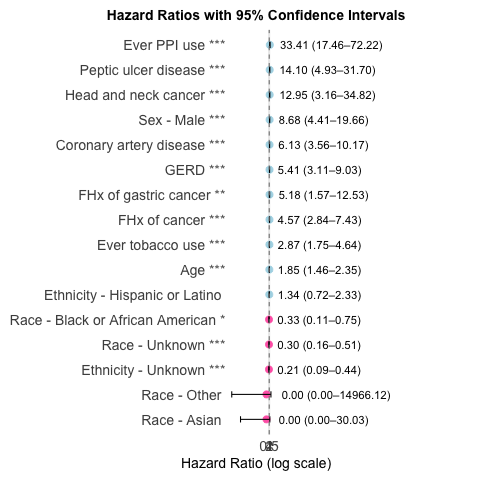

In [80]:
%%R 
pretty_names <- c(
"PPI.PPI1" = "Ever PPI use",
"pud.pud1" = "Peptic ulcer disease",
"hnca.hnca1" = "Head and neck cancer",
"cad.cad1" = "Coronary artery disease", 
"gerd.gerd1" = "GERD",
"famhx_cancer.famhx_cancer1" = "FHx of cancer",
"famhx_gastricca.famhx_gastricca1" = "FHx of gastric cancer",
"ASA.ASA1" = "Ever aspirin use",
"sex_missing.sex_missingMALE" = "Sex - Male",
"tobacco_binary.tobacco_binary1" = "Ever tobacco use",
"NSAID.NSAID1" = "Ever NSAID use",
"age.age" = "Age",
"famhx_colonca.famhx_colonca1" = "FHx of colon cancer",
"ethnicity.ethnicityHispanic or Latino" = "Ethnicity - Hispanic or Latino",
"race_clean.race_cleanAsian" = "Race - Asian",
"race_clean.race_cleanBlack or African American" = "Race - Black or African American",
"race_clean.race_cleanOther" = "Race - Other",
"race_clean.race_cleanNA" = "Race - Unknown",
"race_clean.race_cleanNo matching concept" = "Race - Unknown",
"ethnicity.ethnicityNo matching concept" = "Ethnicity - Unknown",
"weight_baseline.weight_baseline" = "Weight"
)

# Define color and label formatting
forestplot_df <- forestplot_df %>%
  mutate(
    Variable_pretty = pretty_names[Variable_full],
    Variable_pretty = ifelse(is.na(Variable_pretty), Variable_full, Variable_pretty),
    sig = case_when(
      p_value < 0.001 ~ "***",
      p_value < 0.01 ~ "**",
      p_value < 0.05 ~ "*",
      TRUE ~ ""
    ),
    or_label = sprintf("%.2f (%.2f–%.2f)", OR, CI_lower, CI_upper),
    Variable_labeled = paste0(Variable_pretty, " ", sig),  # add asterisks here
    color_group = ifelse(OR >= 1, "OR > 1", "OR < 1")
  ) %>%
  arrange(OR) %>%
  mutate(Variable_labeled = factor(Variable_labeled, levels = unique(Variable_labeled)))

# Plot
ggplot(forestplot_df, aes(x = OR, y = Variable_labeled)) +
  geom_point(aes(color = color_group), size = 3) +
  geom_errorbarh(aes(xmin = CI_lower, xmax = CI_upper), height = 0.25) +
  geom_text(aes(x = CI_upper * 1.05, label = or_label), hjust = -0.1, size = 4) +  # Shows OR + CI
  geom_vline(xintercept = 1, linetype = "dashed", color = "gray50") +
  coord_cartesian(clip = "off") + 
  scale_color_manual(
    values = c("OR > 1" = "lightblue", "OR < 1" = "hotpink"),
    guide = "none"
  ) +
  scale_x_continuous(
    trans = "log10",
    breaks = c(0.5, 1, 2, 4),
    labels = c("0.5", "1", "2", "4"),
    expand = expansion(mult = c(0, 0.25))  # Make room for right-side labels
  ) +
  labs(
    title = "Hazard Ratios with 95% Confidence Intervals",
    x = "Hazard Ratio (log scale)",
    y = NULL
  ) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.y = element_text(size = 14),
    axis.text.x = element_text(size = 14),
    plot.title.position = "panel",
    plot.title = element_text(face = "bold", size = 14, hjust = 0.5),
    panel.grid.major.y = element_blank(),
    panel.grid.minor.x = element_blank(),
    plot.margin = margin(10, 200, 10, 10)  # top, right, bottom, left (in pts)
  )



## Logistic regression multivariate model training

In [81]:
%%R 
library(dplyr)
library(caret)
library(gridExtra)

# Partitions data into training and validation set, percentage split p 
partition_data <- function(data, selected_vars, seed = 123, p = 0.8) {
  rdf <- data %>%
    select(months_to_event, ugica, all_of(subtype_outcomes), all_of(selected_vars)) %>%
    drop_na()
  
  set.seed(seed)
  train_index <- createDataPartition(rdf$ugica_EAC, p = p, list = FALSE)
  
  train_set <- rdf[train_index, ]
  validation_set <- rdf[-train_index, ]
  
  # Check the distribution of 'ugica_EAC' in each set
  print(paste(c("Dataset Controls", "Dataset Cases"), table(rdf$ugica_EAC)))  # Original dataset
  print(paste(c("Training Controls", "Training Cases"), table(train_set$ugica_EAC)))  # Training set
  print(paste(c("Validation Controls", "Validation Cases"), table(validation_set$ugica_EAC)))  # Validation set
  cat("\n")

  list(train_set = train_set, validation_set = validation_set)
}

# Trains model
train_model <- function(train_set, selected_vars, model_func = glm) {
  formula_str <- paste("ugica_EAC ~", paste(selected_vars, collapse = " + "))
  formula <- as.formula(formula_str)
  model <- model_func(formula, data = train_set, family = binomial)
  return(model)
}

# Saves multivariate analysis into filename
save_multivariate_results <- function(logreg_model, multivariate_filename, variable_labels) {

  # Tidy model with variable and level parsed
  multivariate_df <- tidy_plus_plus(
    logreg_model, 
    exponentiate = TRUE,
    variable_labels = variable_labels
  ) %>%
  mutate(
      OR_scaled = estimate / min(estimate, na.rm = TRUE),
      OR_rank = round(OR_scaled)
  )

  # Save to file
  write.csv(multivariate_df, multivariate_filename, row.names = FALSE)
  cat("Multivariate results saved to", multivariate_filename, "\n")

  return(multivariate_df)
}

# Gets risk estimate
calculate_risk <- function(model, validation_set) {  
  risk <- predict(model, newdata = validation_set, type = "response")
  return(risk)
}

# Gets actual event 
count_event <- function(validation_set, outcome, horizon_months = 60) {
  event <- as.numeric(validation_set$months_to_event <= horizon_months & validation_set[[outcome]] == 1)
  return(event)
}

# Get sensitivity and specificity 
calculate_cm_by_percentile <- function(risk, event, threshold) {
    # Convert the continuous risk scores to binary predictions
    predicted_class <- ifelse(risk >= threshold, 1, 0)

    cm <- table(event, predicted_class)

    # Extracting the values from the confusion matrix
    TN <- cm[1, 1]
    FP <- cm[1, 2]
    FN <- cm[2, 1]
    TP <- cm[2, 2]

    # Sensitivity (True Positive Rate)
    sensitivity <- TP / (TP + FN)

    # Specificity (True Negative Rate)
    specificity <- TN / (TN + FP)

    # Positive Predictive Value (PPV) (Precision)
    ppv <- TP / (TP + FP)

    # Negative Predictive Value (NPV)
    npv <- TN / (TN + FN) 

    # Number Needed to Screen (NNS)
    # cer <- (TP + FN) / (TN + FP + FN + TP) # control event rate is cases/entire population 
    cer <- FN / (FN + TN) # control event rate is the number of cases in those not screened 
    ser <- TP / (TP + FP) # screened event rate is the number of cases found / those screened 
    aer <- ser - cer # absolute event reduction 
    nns <- 1/aer 

    # C-statistic (AUROC)
    roc_obj <- roc(event, risk)
    c_statistic <- auc(roc_obj)

    # Print the results
    cat("C-statistic (AUROC):", round(c_statistic, 3), "\n")
    cat("Sensitivity:", sensitivity, "\n")
    cat("Specificity:", specificity, "\n")
    cat("PPV:", ppv, "\n")
    cat("NPV:", npv, "\n")
    cat("NNS:", nns, "\n")
    print(cm)
}

# Plots ROC curve
plot_roc_gg <- function(event, risk) {
  roc_obj <- roc(event, risk, quiet = TRUE)
  df <- data.frame(
    FPR = 1 - roc_obj$specificities,
    TPR = roc_obj$sensitivities
  )
  auroc <- round(auc(roc_obj), 3)

  ggplot(df, aes(x = FPR, y = TPR)) +
    geom_line(color = "navyblue", size = 1.2) +  # Better color
    geom_abline(linetype = "dashed", color = "gray50") +
    annotate("text", x = 0.65, y = 0.05, label = paste("AUROC =", auroc),
             size = 5, hjust = 0, fontface = "italic") +
    labs(
      title = "Receiver Operating Characteristic (ROC) Curve",
      x = "False Positive Rate (1 - Specificity)",
      y = "True Positive Rate (Sensitivity)"
    ) +
    coord_equal() +
    theme_minimal(base_size = 16) +
    theme(
      plot.title = element_text(hjust = 0.5, face = "bold"),
      axis.title = element_text(face = "bold"),
      panel.grid.minor = element_blank(),
      plot.margin = margin(10, 60, 10, 10)  # top, right, bottom, left (in pts)
    )
}

# Plots precision-recall curve
plot_pr_gg <- function(event, risk) {
  pr <- pr.curve(scores.class0 = risk[event == 1], scores.class1 = risk[event == 0], curve = TRUE)
  df <- data.frame(Recall = pr$curve[, 1], Precision = pr$curve[, 2])
  aucpr <- round(pr$auc.integral, 2)

  ggplot(df, aes(x = Recall, y = Precision)) +
    geom_line(color = "darkgreen", size = 1.2) +
    annotate("text", x = 0.6, y = 0.4, label = paste("AUC-PR =", aucpr), size = 5, color = "red") +
    labs(title = "Precision-Recall Curve", x = "Recall", y = "Precision") +
    theme_minimal()
}

# Plots Kaplan-Meier survival curve
plot_km_gg <- function(df, group, ylim = c(0.915, 1.00)) {
  surv_obj <- Surv(time = df$time, event = df$event)
  fit <- survfit(surv_obj ~ group, data = df)

  g <- ggsurvplot(
    fit,
    data = df,
    risk.table = TRUE,
    pval = TRUE,
    conf.int = TRUE,
    xlab = "Months to Event",
    ylab = "Survival Probability",
    ylim = ylim,
    ggtheme = theme_minimal()
  )

  return(g$plot)
}


#### Split dataset into training and validation

In [82]:
%%R 
# Partition data
splits <- partition_data(r_df_normal, selected_vars, p=0.8)
train_set <- splits$train_set
validation_set <- splits$validation_set

# Train model
logreg_model <- train_model(train_set, selected_vars, model_func=glm)

[1] "Dataset Controls 34115" "Dataset Cases 68"      
[1] "Training Controls 27292" "Training Cases 55"      
[1] "Validation Controls 6823" "Validation Cases 13"     



#### Multivariate analysis

In [83]:
%%R 
# Saves hazard ratio from multivariate analysis into file
variable_labels = c(
    hgball_baseline_imputed_mean = "Hemoglobin", 
    sex_missing = "Sex", 
    race_clean = "Race", 
    ethnicity = "Ethnicity", 
    alcohol_binary = "Alcohol", 
    pud = "Peptic ulcer disease",
    gerd = "GERD",
    cad = "Coronary artery disease", 
    barretts = "Barretts esophagus",
    famhx_cancer = "Family history of cancer",
    famhx_gastricca = "Family history of gastric cancer", 
    famhx_colonca = "Family history of colon cancer",
    ASA = "Aspirin use",
    PPI = "Proton pump inhibitor use"
)
multivariate_df <- save_multivariate_results(logreg_model, multivariate_filename, variable_labels)


Multivariate results saved to ./../results/multivariate_analysis_2_eac.csv 


In [84]:
%%R 
names(multivariate_df)

 [1] "term"           "variable"       "var_label"      "var_class"     
 [5] "var_type"       "var_nlevels"    "contrasts"      "contrasts_type"
 [9] "reference_row"  "label"          "n_obs"          "n_event"       
[13] "estimate"       "std.error"      "statistic"      "p.value"       
[17] "conf.low"       "conf.high"      "OR_scaled"      "OR_rank"       


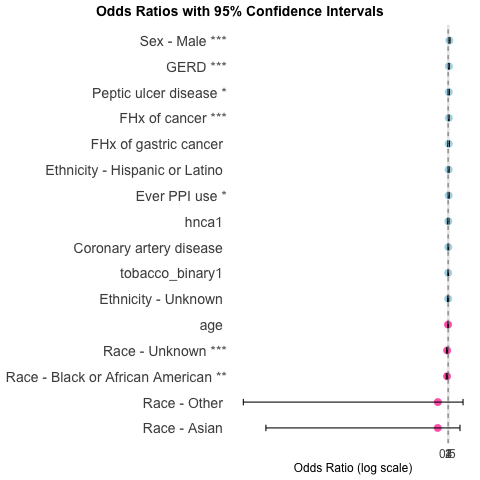

In [85]:
%%R 
pretty_names <- c(
"ethnicityNo matching concept" = "Ethnicity - Unknown",
"alcohol_all2.0" = "Alcohol Use - Current",
"alcohol_all1.0" = "Alcohol Use - Prior",
"alcohol_allNo matching concept" = "Alcohol Use - Unknown",
"ASA1" = "Ever aspirin use",
"tobacco_binary1.0" = "Ever tobacco use",
"NSAID1" = "Ever NSAID use",
"hgb_imputed_scaled" = "Most recent hemoglobin",
"race_cleanOther" = "Race - Other",
"race_cleanNA" = "Race - Unknown",
"ethnicityHispanic or Latino" = "Ethnicity - Hispanic or Latino",
"race_cleanBlack or African American" = "Race - Black or African American",
"age_scaled" = "Age",
"alcohol_binary_missing:tobacco_binary1.0" = "Alcohol + tobacco use interaction",
"race_cleanAsian" = "Race - Asian",
"race_cleanNo matching concept" = "Race - Unknown",
"sex_missingMALE" = "Sex - Male",
"famhx_gastricca1" = "FHx of gastric cancer",
"hpylori_binary1.0" = "Active or chronic H.pylori infection",
"PPI1" = "Ever PPI use",
"barretts1" = "Barretts esophagus",
"cad1" = "Coronary artery disease", 
"famhx_cancer1" = "FHx of cancer",
"famhx_colonca1" = "FHx of colon cancer",
"gerd1" = "GERD",
"pud1" = "Peptic ulcer disease"
)

# Define color and label formatting
multivariate_df <- multivariate_df %>%
  filter(statistic != 0) %>%
  mutate(
    Variable_pretty = pretty_names[term],
    Variable_pretty = ifelse(is.na(Variable_pretty), term, Variable_pretty),
    sig = case_when(
      p.value < 0.001 ~ "***",
      p.value < 0.01 ~ "**",
      p.value < 0.05 ~ "*",
      TRUE ~ ""
    ),
    or_label = sprintf("%.2f (%.2f–%.2f)", estimate, conf.low, conf.high),
    Variable_labeled = paste0(Variable_pretty, " ", sig),  # add asterisks here
    color_group = ifelse(estimate >= 1, "estimate > 1", "estimate < 1")
  ) %>%
  arrange(estimate) %>%
  mutate(Variable_labeled = factor(Variable_labeled, levels = unique(Variable_labeled)))

# Plot
ggplot(multivariate_df, aes(x = estimate, y = Variable_labeled)) +
  geom_point(aes(color = color_group), size = 3) +
  geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), height = 0.25) +
  geom_vline(xintercept = 1, linetype = "dashed", color = "gray50") +
  scale_color_manual(
    values = c("estimate > 1" = "lightblue", "estimate < 1" = "hotpink"),
    guide = "none"
  ) +
  scale_x_continuous(
    trans = "log10",
    breaks = c(0.5, 1, 2, 4),
    labels = c("0.5", "1", "2", "4")
  ) +
  labs(
    title = "Odds Ratios with 95% Confidence Intervals",
    x = "Odds Ratio (log scale)",
    y = NULL
  ) +
  theme_minimal(base_size = 12) +
  theme(
    axis.text.y = element_text(size = 14),
    axis.text.x = element_text(size = 12),
    plot.title.position = "plot",             # Title alignment
    plot.title = element_text(face = "bold", size = 14, hjust = 0.5),  # Centered title
    panel.grid.major.y = element_blank(),
    panel.grid.minor.x = element_blank()
  )


In [86]:
%%R 
# Convert all factor columns in validation_set to character
validation_set[] <- lapply(validation_set, function(x) {
  if (is.factor(x)) as.character(x) else x
})

## Results

### Predict events

In [87]:
%%R 
head(validation_set)

   months_to_event ugica ugica_ESCC ugica_EAC ugica_CGC ugica_NCGC sex_missing
6        59.071869     0          0         0         0          0        MALE
12        4.993840     0          0         0         0          0      FEMALE
14       66.726899     0          0         0         0          0        MALE
23      157.043121     0          0         0         0          0      FEMALE
25        0.164271     0          0         0         0          0        MALE
29      110.948665     0          0         0         0          0        MALE
            race_clean              ethnicity tobacco_binary hnca pud gerd cad
6  No matching concept    No matching concept              0    0   0    0   0
12 No matching concept    No matching concept              0    0   0    1   0
14               White Not Hispanic or Latino              1    0   0    1   0
23 No matching concept     Hispanic or Latino              0    0   0    0   0
25               White Not Hispanic or Latino       

In [88]:
%%R 
# Estimate risk
risk_5_years <- calculate_risk(logreg_model, validation_set)
event_5_years <- count_event(validation_set, "ugica_EAC")

r_df_validation_risk <- data.frame(
    time = validation_set$months_to_event,
    event_eac = validation_set$ugica_EAC,
    race = validation_set$race_clean,
    pred_risk = risk_5_years,
    eac_5yr = event_5_years
)

# Convert variable from int to character before transfer to python
r_df_validation_risk[['race']] <- as.character(r_df_validation_risk[['race']])

# Set risk threshold to calculate sensitivity and specificity
percentile = 70
cat("\nSensitivity and Metrics at 70% Specificity")
threshold <- quantile(risk_5_years, probs = percentile / 100)
calculate_cm_by_percentile(risk_5_years, event_5_years, threshold)


Sensitivity and Metrics at 70% Specificity

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.834 
Sensitivity: 0.8571429 
Specificity: 0.7002489 
PPV: 0.002922552 
NPV: 0.9997909 
NNS: 368.5306 
     predicted_class
event    0    1
    0 4782 2047
    1    1    6


### Sensitivity and Metrics at threshold that maximizes Youdens

In [89]:
%%R
# Find the threshold that maximizes Youden's J (sensitivity + specificity - 1)
roc_obj <- roc(response = event_5_years, predictor = risk_5_years)
optimal_threshold <- coords(
  roc_obj,
  x = "best",
  best.method = "youden",
  transpose = FALSE
)$threshold

cat("\nSensitivity and Metrics at Threshold set by Youden index")
calculate_cm_by_percentile(risk_5_years, event_5_years, optimal_threshold)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases




Sensitivity and Metrics at Threshold set by Youden index

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.834 
Sensitivity: 0.8571429 
Specificity: 0.858398 
PPV: 0.006166495 
NPV: 0.9998294 
NNS: 166.7797 
     predicted_class
event    0    1
    0 5862  967
    1    1    6


### AUROC curves and PR curve

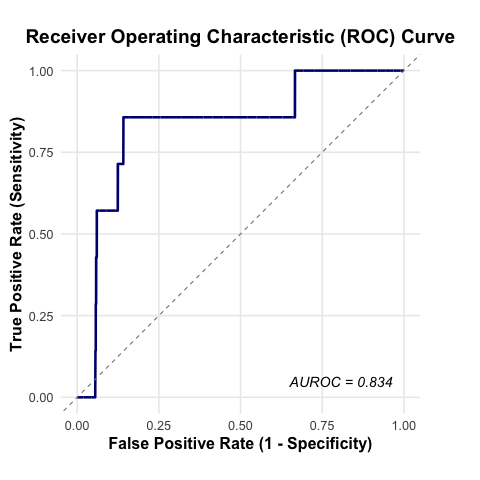

In [90]:
%%R 
# Generate all plots
p1 <- plot_roc_gg(event_5_years, risk_5_years)
p2 <- plot_pr_gg(event_5_years, risk_5_years)
p1

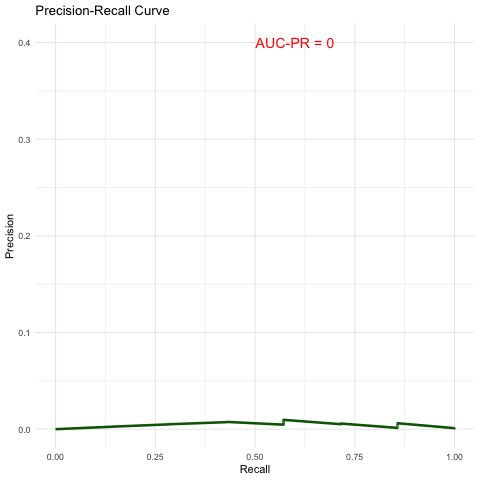

In [91]:
%%R 
p2

### Metrics for each percentile, subdivided by cancer subtype

#### Analysis

In [92]:
r_df_validation_risk = r['r_df_validation_risk']  
df_validation_risk = pandas2ri.rpy2py(r_df_validation_risk)

optimal_threshold = r['optimal_threshold'][0]
optimal_threshold_percentile = percentileofscore(df_validation_risk['pred_risk'], optimal_threshold, kind='weak')/100.

df_validation_risk['actual_percentile'] = df_validation_risk.pred_risk.apply(lambda x: percentileofscore(df_validation_risk['pred_risk'], x, kind='weak')/100.)

# Example inputs
percentile_cutoffs = [0, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99, 1, optimal_threshold_percentile]
percentile_cutoffs_sorted = sorted(set(percentile_cutoffs))
percentile_high_risk = 0.9 # Chosen percentile for high risk group, can vary to compare  

labels = percentile_cutoffs_sorted[:-1]

# Assign risk groups based on custom percentile cutoffs
df_validation_risk['risk_group'] = pd.qcut(
    df_validation_risk['pred_risk'],
    q=percentile_cutoffs_sorted,
    labels=labels,
    duplicates='drop'  # in case there are tied values
)

# One-hot encoding, create a boolean column for each percentile cutoff
for idx, label in enumerate(labels):
    risk_col = f"risk_p{percentile_cutoffs_sorted[idx+1]}"
    include_labels = labels[:idx+1]
    df_validation_risk[risk_col] = np.where(df_validation_risk['risk_group'].isin(include_labels), 0, 1)

# Custom low/high risk cutoff
high_risk_idx = percentile_cutoffs_sorted.index(percentile_high_risk)
df_validation_risk['high_risk'] = np.where(df_validation_risk['risk_group'] == labels[high_risk_idx], 1, 0)

# Optimal Youden threshold cutoff
df_validation_risk['high_risk_youden'] = np.where(df_validation_risk['pred_risk'] >= optimal_threshold, 1, 0)


In [93]:
def classification_metrics(predicted_risk_df, risk_group_name, actual_event_name, race = 'all'):
    predicted_class = predicted_risk_df[risk_group_name]
    actual_class = predicted_risk_df[actual_event_name]

    # Get confusion matrix: TN, FP, FN, TP
    if (predicted_class.sum() == 0):
        return {
        "risk_group": risk_group_name,
        "risk_percentile": float(risk_group_name[6:]) if risk_group_name[0:6] == 'risk_p' else optimal_threshold_percentile, # Get the percentile appended to the end of the risk group name unless youden
        "event": actual_event_name,
        "race": race,
        "actual controls": np.nan,
        "actual cases": np.nan,
        "total pts in risk group": np.nan,
        "cancer prevalence in risk group": np.nan,
        "prevalence": np.nan,
        "tp": np.nan,
        "fp": np.nan,
        "fn": np.nan,
        "tn": np.nan,
        "pred correct": np.nan,
        "pred incorrect": np.nan,
        "sensitivity": np.nan,
        "specificity": np.nan,
        "ppv": np.nan,
        "npv": np.nan,
        "youden_index": np.nan
    }

    tn, fp, fn, tp = confusion_matrix(actual_class, predicted_class).ravel()
    
    # Calculate metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    youden_index = sensitivity + specificity - 1

    total_in_risk_group = predicted_class.sum() #tp+fp
    total_cases_in_risk_group = tp
    prevalence_in_risk_group = round((total_cases_in_risk_group / total_in_risk_group) * 100, 1) 

    return {
        "risk_group": risk_group_name,
        "risk_percentile": float(risk_group_name[6:]) if risk_group_name[0:6] == 'risk_p' else optimal_threshold_percentile, # Get the percentile appended to the end of the risk group name unless youden
        "event": actual_event_name,
        "race": race,
        "actual controls": fp+tn,
        "actual cases": tp+fn,
        "total pts in risk group": total_in_risk_group,
        "cancer prevalence in risk group": f'{total_cases_in_risk_group} ({prevalence_in_risk_group}%)',
        "prevalence": prevalence_in_risk_group,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "tn": tn,
        "pred correct": (tp+tn)/(tp+fp+fn+tn),
        "pred incorrect": (fp+fn)/(tp+fp+fn+tn),
        "sensitivity": sensitivity*100,
        "specificity": specificity*100,
        "ppv": ppv*100,
        "npv": npv*100,
        "youden_index": youden_index
    }


In [94]:
risk_groups = [f"risk_p{percentile_cutoffs[i+1]}" for i in range(len(percentile_cutoffs) - 1)]
events_5yr = ['eac_5yr']
race_groups = df_validation_risk.race.unique()

results_by_riskgroup = []
results_by_race = []

for risk_group in risk_groups:
    for event in events_5yr: 
        row = classification_metrics(df_validation_risk, risk_group, event)
        results_by_riskgroup.append(row)

for race in race_groups:
    df_risk_race = df_validation_risk[df_validation_risk.race == race]

    row = classification_metrics(df_risk_race, "high_risk_youden", "eac_5yr", race)
    results_by_race.append(row)

df_results = pd.DataFrame(results_by_riskgroup)
df_results_race = pd.DataFrame(results_by_race)

#### Metrics for each percentile and cancer subtype, ordered by percentile

In [95]:
df_results.tail()

,risk_group,risk_percentile,event,race,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,youden_index
7,risk_p0.95,0.950000,eac_5yr,all,6829.0,7.0,342.0,0 (0.0%),0.0,0.0,342.0,7.0,6487.0,0.948947,0.051053,0.000000,94.991946,0.00000,99.892208,-0.050081
8,risk_p0.975,0.975000,eac_5yr,all,6829.0,7.0,170.0,0 (0.0%),0.0,0.0,170.0,7.0,6659.0,0.974108,0.025892,0.000000,97.510616,0.00000,99.894989,-0.024894
9,risk_p0.99,0.990000,eac_5yr,all,6829.0,7.0,68.0,0 (0.0%),0.0,0.0,68.0,7.0,6761.0,0.989029,0.010971,0.000000,99.004247,0.00000,99.896572,-0.009958
10,risk_p1,1.000000,eac_5yr,all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,risk_p0.8576653013458163,0.857665,eac_5yr,all,6829.0,7.0,973.0,6 (0.6%),0.6,6.0,967.0,1.0,5862.0,0.858397,0.141603,85.714286,85.839801,0.61665,99.982944,0.715541


#### Metrics for each percentile and cancer subtype, ordered by cancer subtype

In [96]:
df_results.sort_values(by=['event', 'risk_group'])

,risk_group,risk_percentile,event,race,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,youden_index
0,risk_p0.5,0.500000,eac_5yr,all,6829.0,7.0,3418.0,6 (0.2%),0.2,6.0,3412.0,1.0,3417.0,0.500731,0.499269,85.714286,50.036609,0.175541,99.970743,0.357509
1,risk_p0.6,0.600000,eac_5yr,all,6829.0,7.0,2732.0,6 (0.2%),0.2,6.0,2726.0,1.0,4103.0,0.601083,0.398917,85.714286,60.082003,0.219619,99.975634,0.457963
2,risk_p0.7,0.700000,eac_5yr,all,6829.0,7.0,2050.0,6 (0.3%),0.3,6.0,2044.0,1.0,4785.0,0.700848,0.299152,85.714286,70.068824,0.292683,99.979106,0.557831
3,risk_p0.75,0.750000,eac_5yr,all,6829.0,7.0,1709.0,6 (0.4%),0.4,6.0,1703.0,1.0,5126.0,0.750731,0.249269,85.714286,75.062235,0.351083,99.980495,0.607765
4,risk_p0.8,0.800000,eac_5yr,all,6829.0,7.0,1362.0,6 (0.4%),0.4,6.0,1356.0,1.0,5473.0,0.801492,0.198508,85.714286,80.143506,0.440529,99.981732,0.658578
5,risk_p0.85,0.850000,eac_5yr,all,6829.0,7.0,1026.0,6 (0.6%),0.6,6.0,1020.0,1.0,5809.0,0.850644,0.149356,85.714286,85.063699,0.584795,99.982788,0.707780
11,risk_p0.8576653013458163,0.857665,eac_5yr,all,6829.0,7.0,973.0,6 (0.6%),0.6,6.0,967.0,1.0,5862.0,0.858397,0.141603,85.714286,85.839801,0.616650,99.982944,0.715541
6,risk_p0.9,0.900000,eac_5yr,all,6829.0,7.0,684.0,4 (0.6%),0.6,4.0,680.0,3.0,6149.0,0.900088,0.099912,57.142857,90.042466,0.584795,99.951235,0.471853
7,risk_p0.95,0.950000,eac_5yr,all,6829.0,7.0,342.0,0 (0.0%),0.0,0.0,342.0,7.0,6487.0,0.948947,0.051053,0.000000,94.991946,0.000000,99.892208,-0.050081
8,risk_p0.975,0.975000,eac_5yr,all,6829.0,7.0,170.0,0 (0.0%),0.0,0.0,170.0,7.0,6659.0,0.974108,0.025892,0.000000,97.510616,0.000000,99.894989,-0.024894


In [97]:
df_results.to_csv(risk_results_filename)

### Performance metrics by race at the optimal risk percentile

In [98]:
df_results_race

,risk_group,risk_percentile,event,race,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,youden_index
0,high_risk_youden,0.857665,eac_5yr,No matching concept,2337.0,1.0,167.0,0 (0.0%),0.0,0.0,167.0,1.0,2170.0,0.928144,0.071856,0.0,92.854086,0.000000,99.953938,-0.071459
1,high_risk_youden,0.857665,eac_5yr,White,2526.0,6.0,780.0,6 (0.8%),0.8,6.0,774.0,0.0,1752.0,0.694313,0.305687,100.0,69.358670,0.769231,100.000000,0.693587
2,high_risk_youden,0.857665,eac_5yr,Black or African American,1476.0,0.0,26.0,0 (0.0%),0.0,0.0,26.0,0.0,1450.0,0.982385,0.017615,0.0,98.238482,0.000000,100.000000,-0.017615
3,high_risk_youden,0.857665,eac_5yr,Asian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,high_risk_youden,0.857665,eac_5yr,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
df_results_race.to_csv(risk_results_race_filename)

### Prevalance of cancer as a function of risk percentile by subtype

In [100]:
event_pretty_label = {
    "ugica_5yr": "UGI cancer", 
    "escc_5yr": "Esophageal SCC",
    "eac_5yr": "Esophageal AC",
    "cgc_5yr": "Cardia Gastric AC",
    "ncgc_5yr": "Noncardia Gastric AC"
}

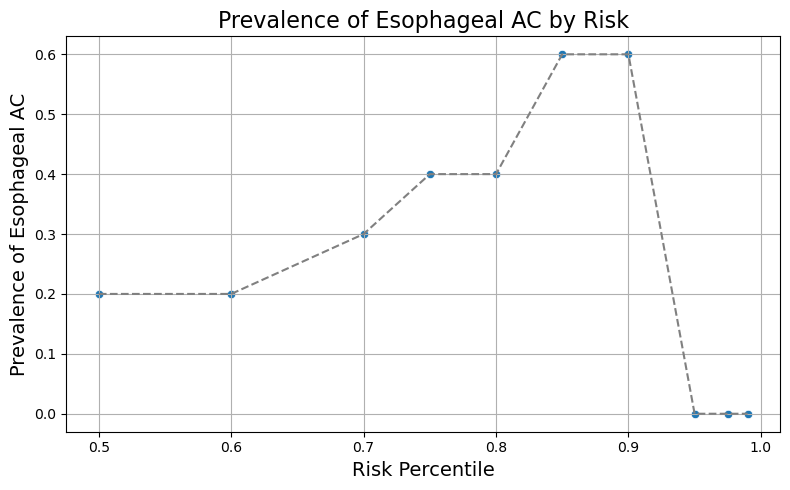

In [101]:
df_results_plot = df_results[df_results['risk_percentile'] != optimal_threshold_percentile]

for event in events_5yr:
    # Plot the scatterplot
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df_results_plot[df_results_plot.event == event], x='risk_percentile', y='prevalence')

    # Optionally add a line to show trend
    sns.lineplot(data=df_results_plot[df_results_plot.event == event], x='risk_percentile', y='prevalence', color='gray', linestyle='--')


    # Axis labels and title
    plt.xlabel("Risk Percentile", fontsize=14)
    plt.ylabel(f'Prevalence of {event_pretty_label[event]}', fontsize=14)
    plt.title(f'Prevalence of {event_pretty_label[event]} by Risk', fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Save model, threshold and validation set

In [102]:
%%R 
# Save model
saveRDS(logreg_model, "logreg_eac.rds")

In [103]:
# Save optimal threshold 
import json
import os

def save_to_json(variable, filename, key=None):
    # If the file exists, load existing data
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            try:
                data = json.load(f)
            except json.JSONDecodeError:
                data = {}
    else:
        data = {}

    # Append or update data
    if key in data:
        data[key].update(variable)
    else: 
        data[key] = variable

    # Save the updated data
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)

    print(f"Saved to {filename}")


In [104]:
model = 'logreg'
subtype = 'eac'
selected_vars = list(r['selected_vars'])  

model_variables = {
    subtype: {
        "threshold": optimal_threshold,
        "variables": selected_vars
    }
}

# Save
save_to_json(model_variables, "thresholds.json", key=model)

Saved to thresholds.json
